<a href="https://colab.research.google.com/github/shariqfz/Fake-News-Detection-Text-Classification/blob/main/RandomForestClassifier/RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import re
import pandas as pd

In [ ]:
# Importing necessary paackages

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.ensemble import RandomForestClassifier


seed = 5343

In [ ]:
%%capture
#Get Original dataset
!mkdir -p data
!git clone 'https://github.com/shariqfz/Fake-News-Detection-Text-Classification.git'
!tar -zxvf '/content/Fake-News-Detection-Text-Classification/data/FakeNewsData.tar.gz'
!mv ./FakeNewsData/Fake.csv ./FakeNewsData/True.csv ./data
!rm -r /content/FakeNewsData /content/sample_data

In [ ]:
true = pd.read_csv('/content/data/True.csv')
fake = pd.read_csv('/content/data/Fake.csv')

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# Introducing new column in both dataframes

true['impression']=1
fake['impression']=0

In [ ]:
# Concatenating them using pandas concatenate to form a single dataframe

data_raw = pd.concat([true, fake], axis=0)
data_raw.sample(10)

,title,text,subject,date,impression
1472,Kellyanne Conway Just Can’t Stop Talking Abou...,With nothing else important going on in the wo...,News,"May 14, 2017",0
21972,Reflections on a World Gone Mad and Pushing Ba...,Andre Vltchek Anti DiplomaticoThe following i...,US_News,"October 14, 2017",0
3440,Kremlin says Paris climate deal unworkable wit...,MOSCOW (Reuters) - The Paris climate deal is u...,politicsNews,"June 2, 2017",1
21228,France unveils labor reforms in first step to ...,PARIS (Reuters) - French President Emmanuel Ma...,worldnews,"August 31, 2017",1
21844,JEB BUSH WANTS CONGRESS TO APPROVE AMNESTY And...,Jeb Bush just unofficially placed himself on t...,left-news,"Apr 17, 2015",0
20044,Yemen's Houthi leader says could target Saudi ...,DUBAI (Reuters) - Yemen s Houthi leader Abdel-...,worldnews,"September 14, 2017",1
23264,No Longer a Fantasy: Could Hillary Clinton Act...,21st Century Wire says US Democratic Party can...,Middle-east,"September 13, 2016",0
5545,Seven-Year-Old Boy Accidentally Kills Father ...,"A seven-year-old Alma, Michigan boy accidental...",News,"July 8, 2016",0
16040,Blast in Afghan capital causes numerous casual...,KABUL (Reuters) - A blast in the Afghan capita...,worldnews,"October 31, 2017",1
3306,Prince Charles Reminds Everyone What the 1930...,"Over the years, when we Americans have gotten ...",News,"December 22, 2016",0


In [ ]:
# Combining title and text to obtain a single string
# dropping title and

data_raw['fulltext'] = data_raw.title + ' ' + data_raw.text
data_raw.drop(['title','text'], axis=1, inplace=True)

In [ ]:
# Extracting a new dataframe using features fulltext and impression
data = data_raw[['fulltext', 'impression']]
data = data.reset_index()
data.drop(['index'], axis=1, inplace=True)

In [ ]:
# Check for missing values

data.isnull().sum()

fulltext      0
impression    0
dtype: int64

In [ ]:
print('The dataset contans {} rows and {} columns'.format(data.shape[0], data.shape[1]))

The dataset contans 44898 rows and 2 columns


In [ ]:
# Word extraction from true and fake texts

true_text = data[data.impression==1]['fulltext']
fake_text = data[data.impression==0]['fulltext']
fake_text = fake_text.reset_index().drop(['index'], axis=1)

In [ ]:
import nltk
nltk.download('all')


In [ ]:
# Function to extract major words from true and fake news

def wordcloud_words(X_data_full):

    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2

    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full[i])
        X_data_full_clear_punct.append(test_data)

    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2

    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full[i])
        X_data_full_clear_stopwords.append(test_data)

    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words

    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full[i])
        X_data_full_tokenized_words.append(test_data)

    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words

    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full[i])
        X_data_full_lemmatized_words.append(test_data)

    return X_data_full_lemmatized_words

In [ ]:
true_text[:1000]

0      As U.S. budget fight looms, Republicans flip t...
1      U.S. military to accept transgender recruits o...
2      Senior U.S. Republican senator: 'Let Mr. Muell...
3      FBI Russia probe helped by Australian diplomat...
4      Trump wants Postal Service to charge 'much mor...
                             ...                        
995    House panels seek documents on Puerto Rico uti...
996    Trump releases some JFK files, blocks others u...
997    Tillerson tells Myanmar army chief U.S. concer...
998    Exclusive: While advising Trump in 2016, ex-CI...
999    Mattis visits Seoul for defense talks as tensi...
Name: fulltext, Length: 1000, dtype: object

In [ ]:
true_words = wordcloud_words(true_text[:1000])
fake_words = wordcloud_words(fake_text[:1000].fulltext)

In [ ]:
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color = 'black',
                         max_words = 3000,
                         width=1600,
                         height=800).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

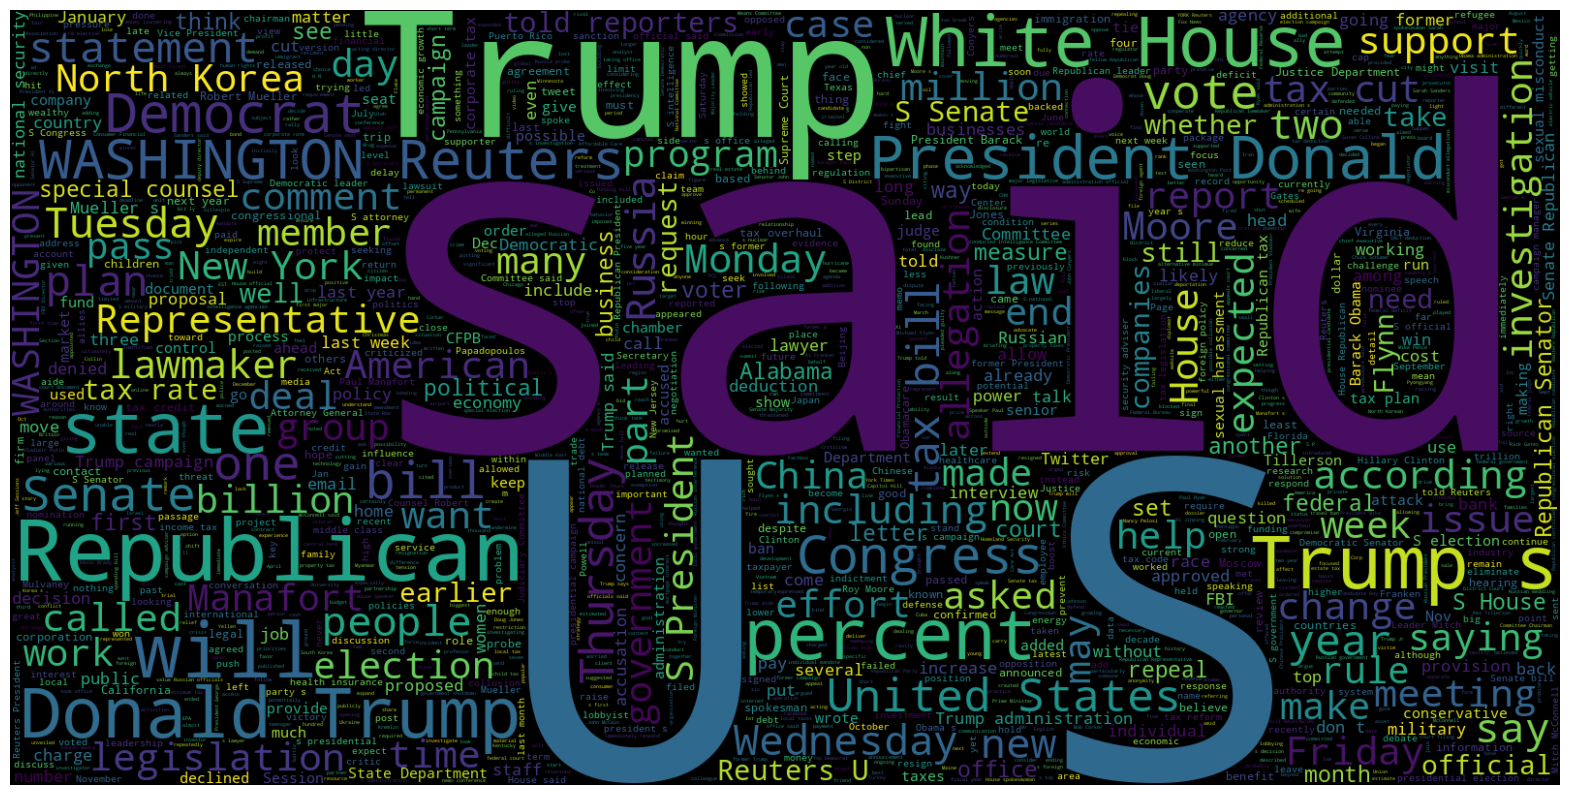

In [ ]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(true_words))

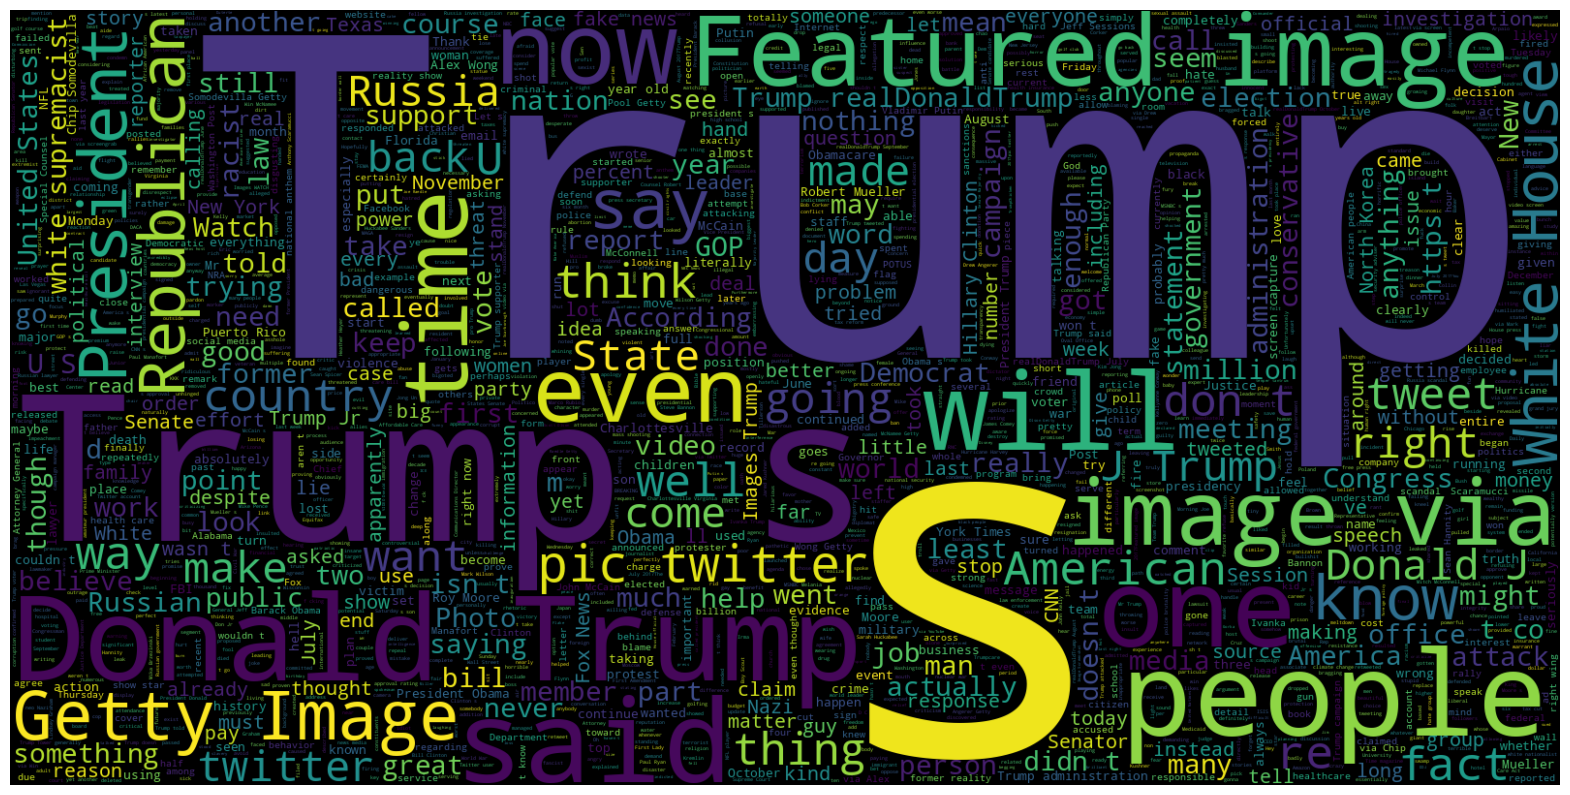

In [ ]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(fake_words))